# Washing Machine Vibration Analysis & Failure Prediction
## IoT Edge-Analytics for Smart Appliance Monitoring

**Hardware**: IndusBoard Coin V2 (ESP32-S2) with LSM303AGR Accelerometer  
**Data Source**: 3-axis accelerometer readings (X, Y, Z) at 100 Hz  
**Objective**: 
1. **Part 1**: Classify washing machine stages from vibration patterns
2. **Part 2**: Predict drum failures and anomalies

---


## Import Libraries


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0


## Data Loading & Exploration


In [ ]:
# Load merged data files
# Status mapping: 0 = STOPPED, 1 = RINSING/SLOW_SPIN, 2 = HIGH_SPEED/DRY

def load_merged_data(filepath, stage_type='train'):
    """Load vibration data from merged CSV file with status column"""
    try:
        # Read CSV with X, Y, Z, status columns
        df = pd.read_csv(filepath, header=None, names=['X', 'Y', 'Z', 'status'])
        
        # Map status codes to labels
        status_map = {
            0: 'STOPPED',
            1: 'RINSING_SLOW_SPIN',
            2: 'HIGH_SPEED_DRY'
        }
        df['label'] = df['status'].map(status_map)
        df['stage_type'] = stage_type
        
        # Calculate magnitude (resultant vector)
        df['magnitude'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
        
        return df
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Load training and test data
print("Loading merged data files...")
df_train = load_merged_data('data/merged_train.csv', stage_type='train')
df_test = load_merged_data('data/merged_test.csv', stage_type='test')

if df_train is not None:
    print(f"Loaded merged_train.csv: {len(df_train)} samples")
    print(f"  Status distribution: {df_train['status'].value_counts().sort_index()}")
    
if df_test is not None:
    print(f"Loaded merged_test.csv: {len(df_test)} samples")
    print(f"  Status distribution: {df_test['status'].value_counts().sort_index()}")

# Combine train and test data for EDA (we'll split later for modeling)
df_combined = pd.concat([df_train, df_test], ignore_index=True)

print(f"\nTotal combined data: {len(df_combined)} samples")
print(f"\nData shape: {df_combined.shape}")
print(f"\nLabel distribution:")
print(df_combined['label'].value_counts())
print(f"\nStatus code distribution:")
print(df_combined['status'].value_counts().sort_index())


Loading merged data files...
Loaded merged_train.csv: 16020 samples
  Status distribution: status
0    4988
1    7032
2    4000
Name: count, dtype: int64
Loaded merged_test.csv: 11425 samples
  Status distribution: status
0    4214
1    4214
2    2997
Name: count, dtype: int64

Total combined data: 27445 samples

Data shape: (27445, 7)

Label distribution:
label
RINSING_SLOW_SPIN    11246
STOPPED               9202
HIGH_SPEED_DRY        6997
Name: count, dtype: int64

Status code distribution:
status
0     9202
1    11246
2     6997
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)


In [7]:
# Basic statistics
print("=== Basic Statistics ===")
print(df_combined.describe())
print("\n=== Missing Values ===")
print(df_combined.isnull().sum())
print("\n=== Data Types ===")
print(df_combined.dtypes)


=== Basic Statistics ===
                  X             Y             Z        status     magnitude
count  27445.000000  27445.000000  27445.000000  27445.000000  27445.000000
mean     -13.064602     -4.127819  -1002.526835      0.919657   1032.873185
std      180.614738    173.388718     82.423408      0.764069     88.867697
min     -592.000000   -631.000000  -1579.000000      0.000000    662.952487
25%      -34.000000    -26.000000  -1009.000000      0.000000    997.723910
50%      -22.000000      4.000000  -1001.000000      1.000000   1005.463575
75%       27.000000     12.000000   -997.000000      2.000000   1014.043885
max      616.000000    550.000000   -436.000000      2.000000   1652.580104

=== Missing Values ===
X             0
Y             0
Z             0
status        0
label         0
stage_type    0
magnitude     0
dtype: int64

=== Data Types ===
X               int64
Y               int64
Z               int64
status          int64
label             str
stage_type  

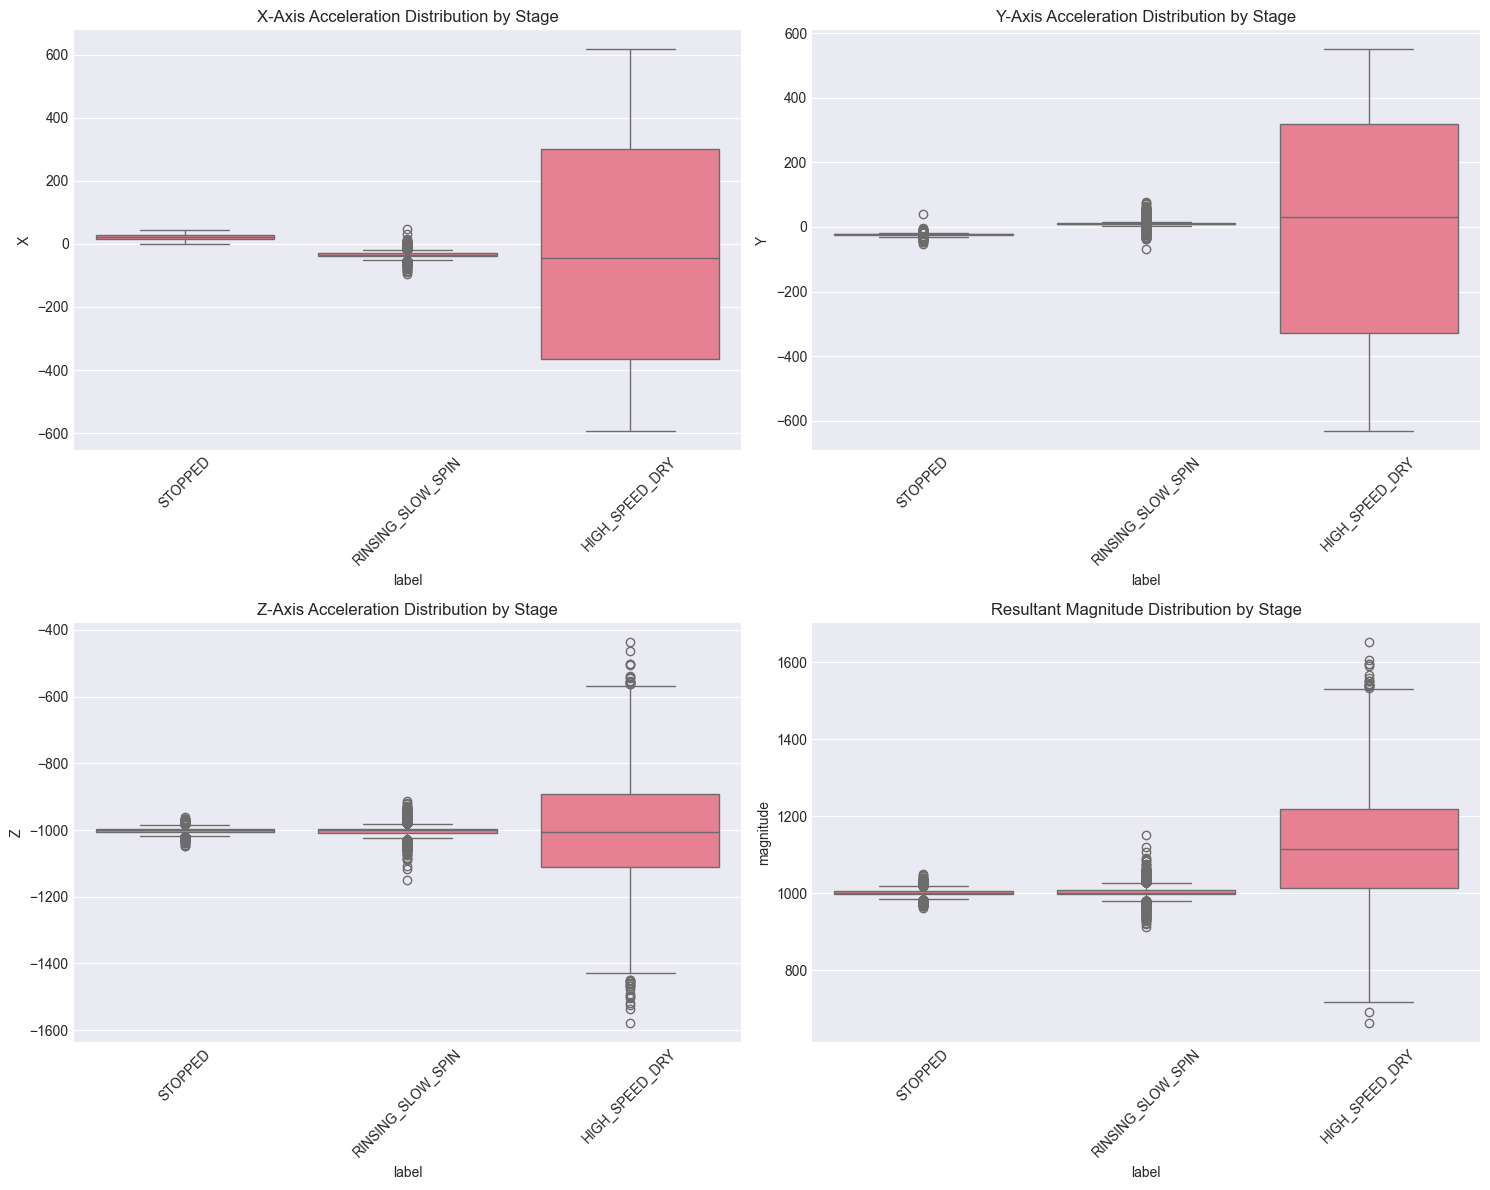

In [8]:
# Visualize distribution of each axis by label
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# X-axis distribution
sns.boxplot(data=df_combined, x='label', y='X', ax=axes[0, 0])
axes[0, 0].set_title('X-Axis Acceleration Distribution by Stage')
axes[0, 0].tick_params(axis='x', rotation=45)

# Y-axis distribution
sns.boxplot(data=df_combined, x='label', y='Y', ax=axes[0, 1])
axes[0, 1].set_title('Y-Axis Acceleration Distribution by Stage')
axes[0, 1].tick_params(axis='x', rotation=45)

# Z-axis distribution
sns.boxplot(data=df_combined, x='label', y='Z', ax=axes[1, 0])
axes[1, 0].set_title('Z-Axis Acceleration Distribution by Stage')
axes[1, 0].tick_params(axis='x', rotation=45)

# Magnitude distribution
sns.boxplot(data=df_combined, x='label', y='magnitude', ax=axes[1, 1])
axes[1, 1].set_title('Resultant Magnitude Distribution by Stage')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


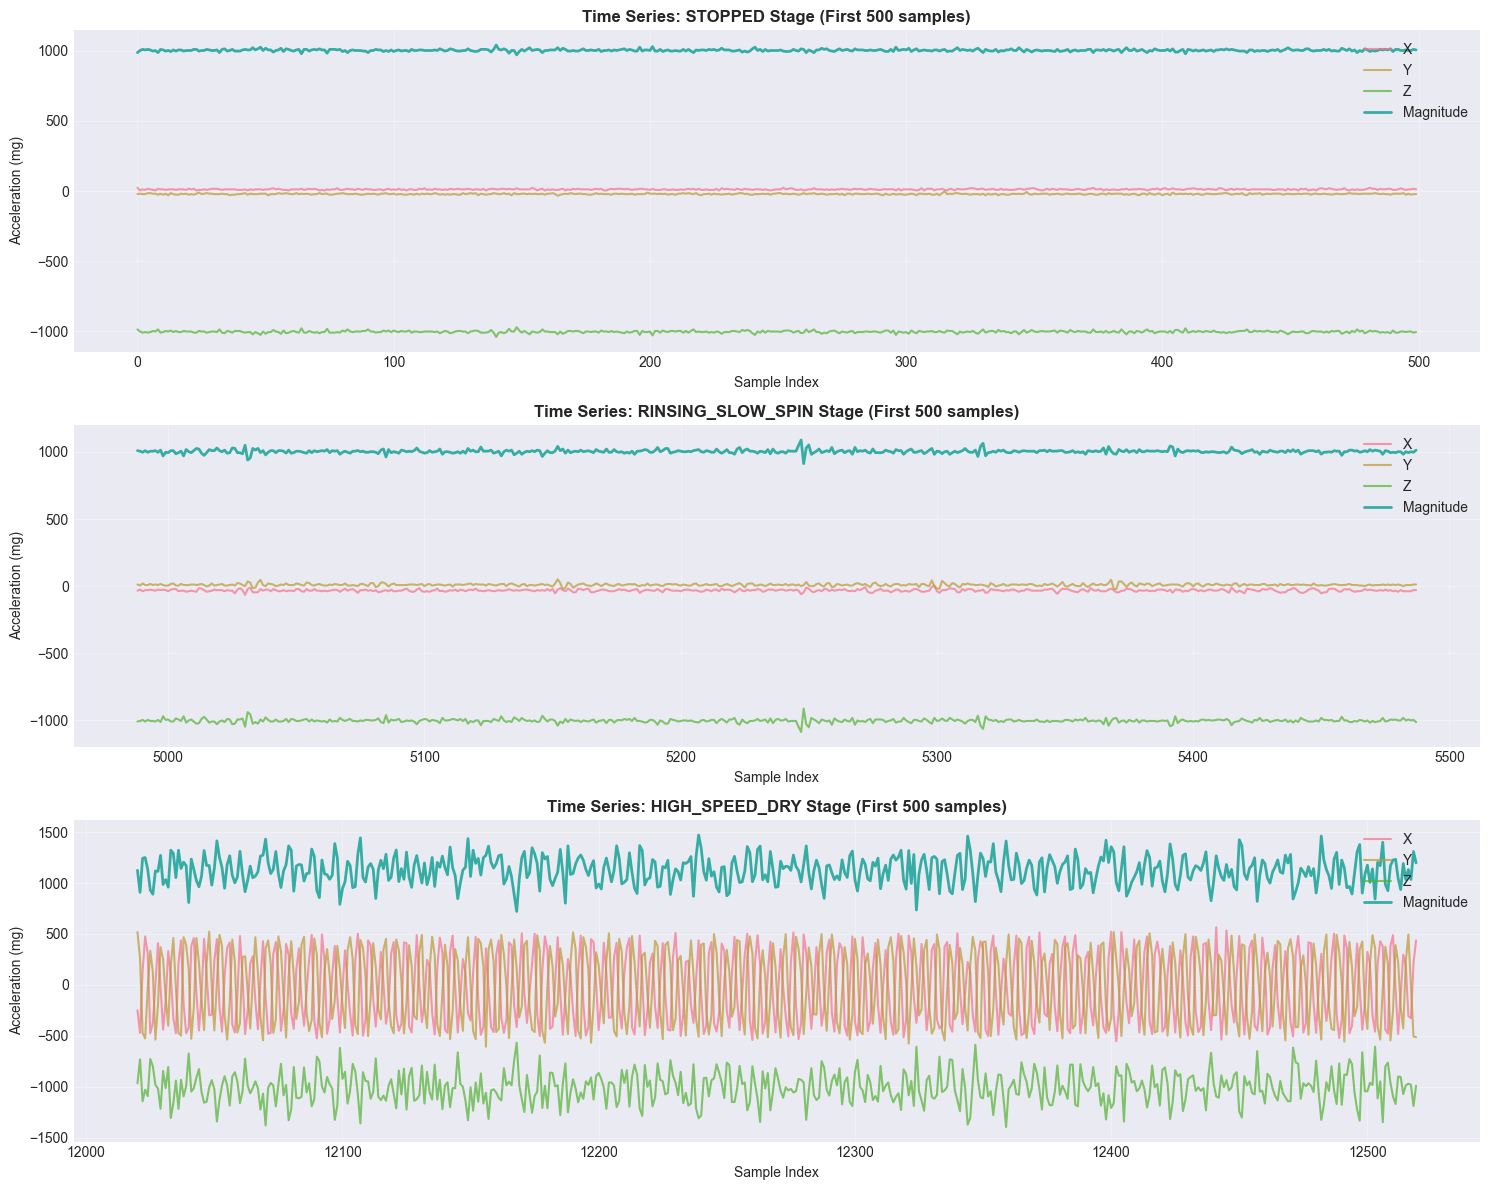

In [9]:
# Time series visualization for each stage
stages = df_combined['label'].unique()
fig, axes = plt.subplots(len(stages), 1, figsize=(15, 4*len(stages)))

for idx, stage in enumerate(stages):
    stage_data = df_combined[df_combined['label'] == stage].head(500)  # First 500 samples
    
    axes[idx].plot(stage_data.index, stage_data['X'], label='X', alpha=0.7)
    axes[idx].plot(stage_data.index, stage_data['Y'], label='Y', alpha=0.7)
    axes[idx].plot(stage_data.index, stage_data['Z'], label='Z', alpha=0.7)
    axes[idx].plot(stage_data.index, stage_data['magnitude'], label='Magnitude', linewidth=2)
    
    axes[idx].set_title(f'Time Series: {stage} Stage (First 500 samples)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Acceleration (mg)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Statistical features by stage
stage_stats = df_combined.groupby('label').agg({
    'X': ['mean', 'std', 'min', 'max'],
    'Y': ['mean', 'std', 'min', 'max'],
    'Z': ['mean', 'std', 'min', 'max'],
    'magnitude': ['mean', 'std', 'min', 'max']
}).round(2)

print("=== Statistical Features by Stage ===")
print(stage_stats)


=== Statistical Features by Stage ===
                       X                        Y                          Z  \
                    mean     std  min  max   mean     std  min  max     mean   
label                                                                          
HIGH_SPEED_DRY    -28.63  354.03 -592  616  -0.54  342.04 -631  550 -1001.70   
RINSING_SLOW_SPIN -32.23    7.72  -97   47   9.75    7.37  -69   78 -1002.91   
STOPPED            22.19    7.38    0   43 -23.81    4.33  -54   39 -1002.68   

                                     magnitude                           
                      std   min  max      mean     std     min      max  
label                                                                    
HIGH_SPEED_DRY     162.31 -1579 -436   1118.99  143.95  662.95  1652.58  
RINSING_SLOW_SPIN   12.04 -1150 -912   1003.54   12.03  913.19  1150.28  
STOPPED              7.37 -1048 -962   1003.24    7.35  962.43  1049.42  


## Synthetic Fault Data Generation

Since we don't have actual fault data, we'll generate synthetic fault patterns based on common washing machine failures:
1. **Unbalanced Drum**: Irregular, high-amplitude vibrations
2. **Bearing Failure**: High-frequency noise with increasing amplitude
3. **Motor Malfunction**: Erratic, non-periodic vibrations
4. **Belt Slippage**: Sudden drops in vibration amplitude
5. **Drum Misalignment**: Asymmetric vibration patterns


In [11]:
def generate_fault_data(base_stage_data, fault_type, n_samples=1000):
    """
    Generate synthetic fault data based on different failure modes
    
    Parameters:
    - base_stage_data: DataFrame with normal stage data
    - fault_type: Type of fault ('unbalanced', 'bearing', 'motor', 'belt', 'misalignment')
    - n_samples: Number of samples to generate
    """
    np.random.seed(42)
    
    # Get base statistics
    base_mean = base_stage_data[['X', 'Y', 'Z']].mean().values
    base_std = base_stage_data[['X', 'Y', 'Z']].std().values
    
    fault_data = []
    
    for i in range(n_samples):
        if fault_type == 'unbalanced':
            # Unbalanced drum: High amplitude spikes with irregular pattern
            spike = np.random.choice([0, 1], p=[0.7, 0.3])  # 30% chance of spike
            if spike:
                x = base_mean[0] + np.random.normal(0, base_std[0] * 4) + np.random.uniform(-500, 500)
                y = base_mean[1] + np.random.normal(0, base_std[1] * 4) + np.random.uniform(-500, 500)
                z = base_mean[2] + np.random.normal(0, base_std[2] * 4) + np.random.uniform(-500, 500)
            else:
                x = base_mean[0] + np.random.normal(0, base_std[0] * 1.5)
                y = base_mean[1] + np.random.normal(0, base_std[1] * 1.5)
                z = base_mean[2] + np.random.normal(0, base_std[2] * 1.5)
                
        elif fault_type == 'bearing':
            # Bearing failure: High-frequency noise with increasing amplitude
            t = i / 100.0  # Time progression
            high_freq = 10 * np.sin(2 * np.pi * 20 * t)  # 20 Hz component
            amplitude_increase = 1 + 0.001 * t  # Gradually increasing
            
            x = base_mean[0] + np.random.normal(0, base_std[0]) + high_freq * amplitude_increase * 50
            y = base_mean[1] + np.random.normal(0, base_std[1]) + high_freq * amplitude_increase * 50
            z = base_mean[2] + np.random.normal(0, base_std[2]) + high_freq * amplitude_increase * 50
            
        elif fault_type == 'motor':
            # Motor malfunction: Erratic, non-periodic vibrations
            erratic_factor = np.random.uniform(-3, 3)
            x = base_mean[0] + np.random.normal(0, base_std[0] * (2 + abs(erratic_factor)))
            y = base_mean[1] + np.random.normal(0, base_std[1] * (2 + abs(erratic_factor)))
            z = base_mean[2] + np.random.normal(0, base_std[2] * (2 + abs(erratic_factor)))
            
            # Add sudden jumps
            if np.random.random() < 0.1:  # 10% chance
                jump = np.random.uniform(-300, 300)
                x += jump
                y += jump * 0.7
                z += jump * 0.5
                
        elif fault_type == 'belt':
            # Belt slippage: Sudden drops in vibration
            drop = np.random.choice([0, 1], p=[0.8, 0.2])  # 20% chance of drop
            if drop:
                x = base_mean[0] + np.random.normal(0, base_std[0] * 0.3)  # 70% reduction
                y = base_mean[1] + np.random.normal(0, base_std[1] * 0.3)
                z = base_mean[2] + np.random.normal(0, base_std[2] * 0.3)
            else:
                x = base_mean[0] + np.random.normal(0, base_std[0] * 1.2)
                y = base_mean[1] + np.random.normal(0, base_std[1] * 1.2)
                z = base_mean[2] + np.random.normal(0, base_std[2] * 1.2)
                
        elif fault_type == 'misalignment':
            # Drum misalignment: Asymmetric vibration patterns
            # One axis has significantly different behavior
            axis_choice = np.random.choice([0, 1, 2])
            
            x = base_mean[0] + np.random.normal(0, base_std[0])
            y = base_mean[1] + np.random.normal(0, base_std[1])
            z = base_mean[2] + np.random.normal(0, base_std[2])
            
            # Amplify one axis
            if axis_choice == 0:
                x += np.random.normal(0, base_std[0] * 3)
            elif axis_choice == 1:
                y += np.random.normal(0, base_std[1] * 3)
            else:
                z += np.random.normal(0, base_std[2] * 3)
        
        magnitude = np.sqrt(x**2 + y**2 + z**2)
        fault_data.append([x, y, z, magnitude])
    
    fault_df = pd.DataFrame(fault_data, columns=['X', 'Y', 'Z', 'magnitude'])
    fault_df['label'] = f'FAULT_{fault_type.upper()}'
    fault_df['stage_type'] = 'train'
    
    return fault_df

# Generate fault data for different stages
fault_types = ['unbalanced', 'bearing', 'motor', 'belt', 'misalignment']
fault_dataframes = []

# Generate faults for high speed/dry stage (most common failure scenario)
high_speed_data = df_combined[df_combined['label'] == 'HIGH_SPEED_DRY']

for fault_type in fault_types:
    fault_df = generate_fault_data(high_speed_data, fault_type, n_samples=1000)
    fault_dataframes.append(fault_df)
    print(f"Generated {len(fault_df)} samples for {fault_type} fault")

# Also generate some faults for other stages
rinsing_data = df_combined[df_combined['label'] == 'RINSING_SLOW_SPIN']
for fault_type in ['unbalanced', 'motor']:
    fault_df = generate_fault_data(rinsing_data, fault_type, n_samples=500)
    fault_dataframes.append(fault_df)
    print(f"Generated {len(fault_df)} samples for {fault_type} fault (RINSING_SLOW_SPIN stage)")

# Combine fault data
df_faults = pd.concat(fault_dataframes, ignore_index=True)
print(f"\nTotal fault samples generated: {len(df_faults)}")
print(f"\nFault type distribution:")
print(df_faults['label'].value_counts())


Generated 1000 samples for unbalanced fault
Generated 1000 samples for bearing fault
Generated 1000 samples for motor fault
Generated 1000 samples for belt fault
Generated 1000 samples for misalignment fault
Generated 500 samples for unbalanced fault (RINSING_SLOW_SPIN stage)
Generated 500 samples for motor fault (RINSING_SLOW_SPIN stage)

Total fault samples generated: 6000

Fault type distribution:
label
FAULT_UNBALANCED      1500
FAULT_MOTOR           1500
FAULT_BEARING         1000
FAULT_BELT            1000
FAULT_MISALIGNMENT    1000
Name: count, dtype: int64


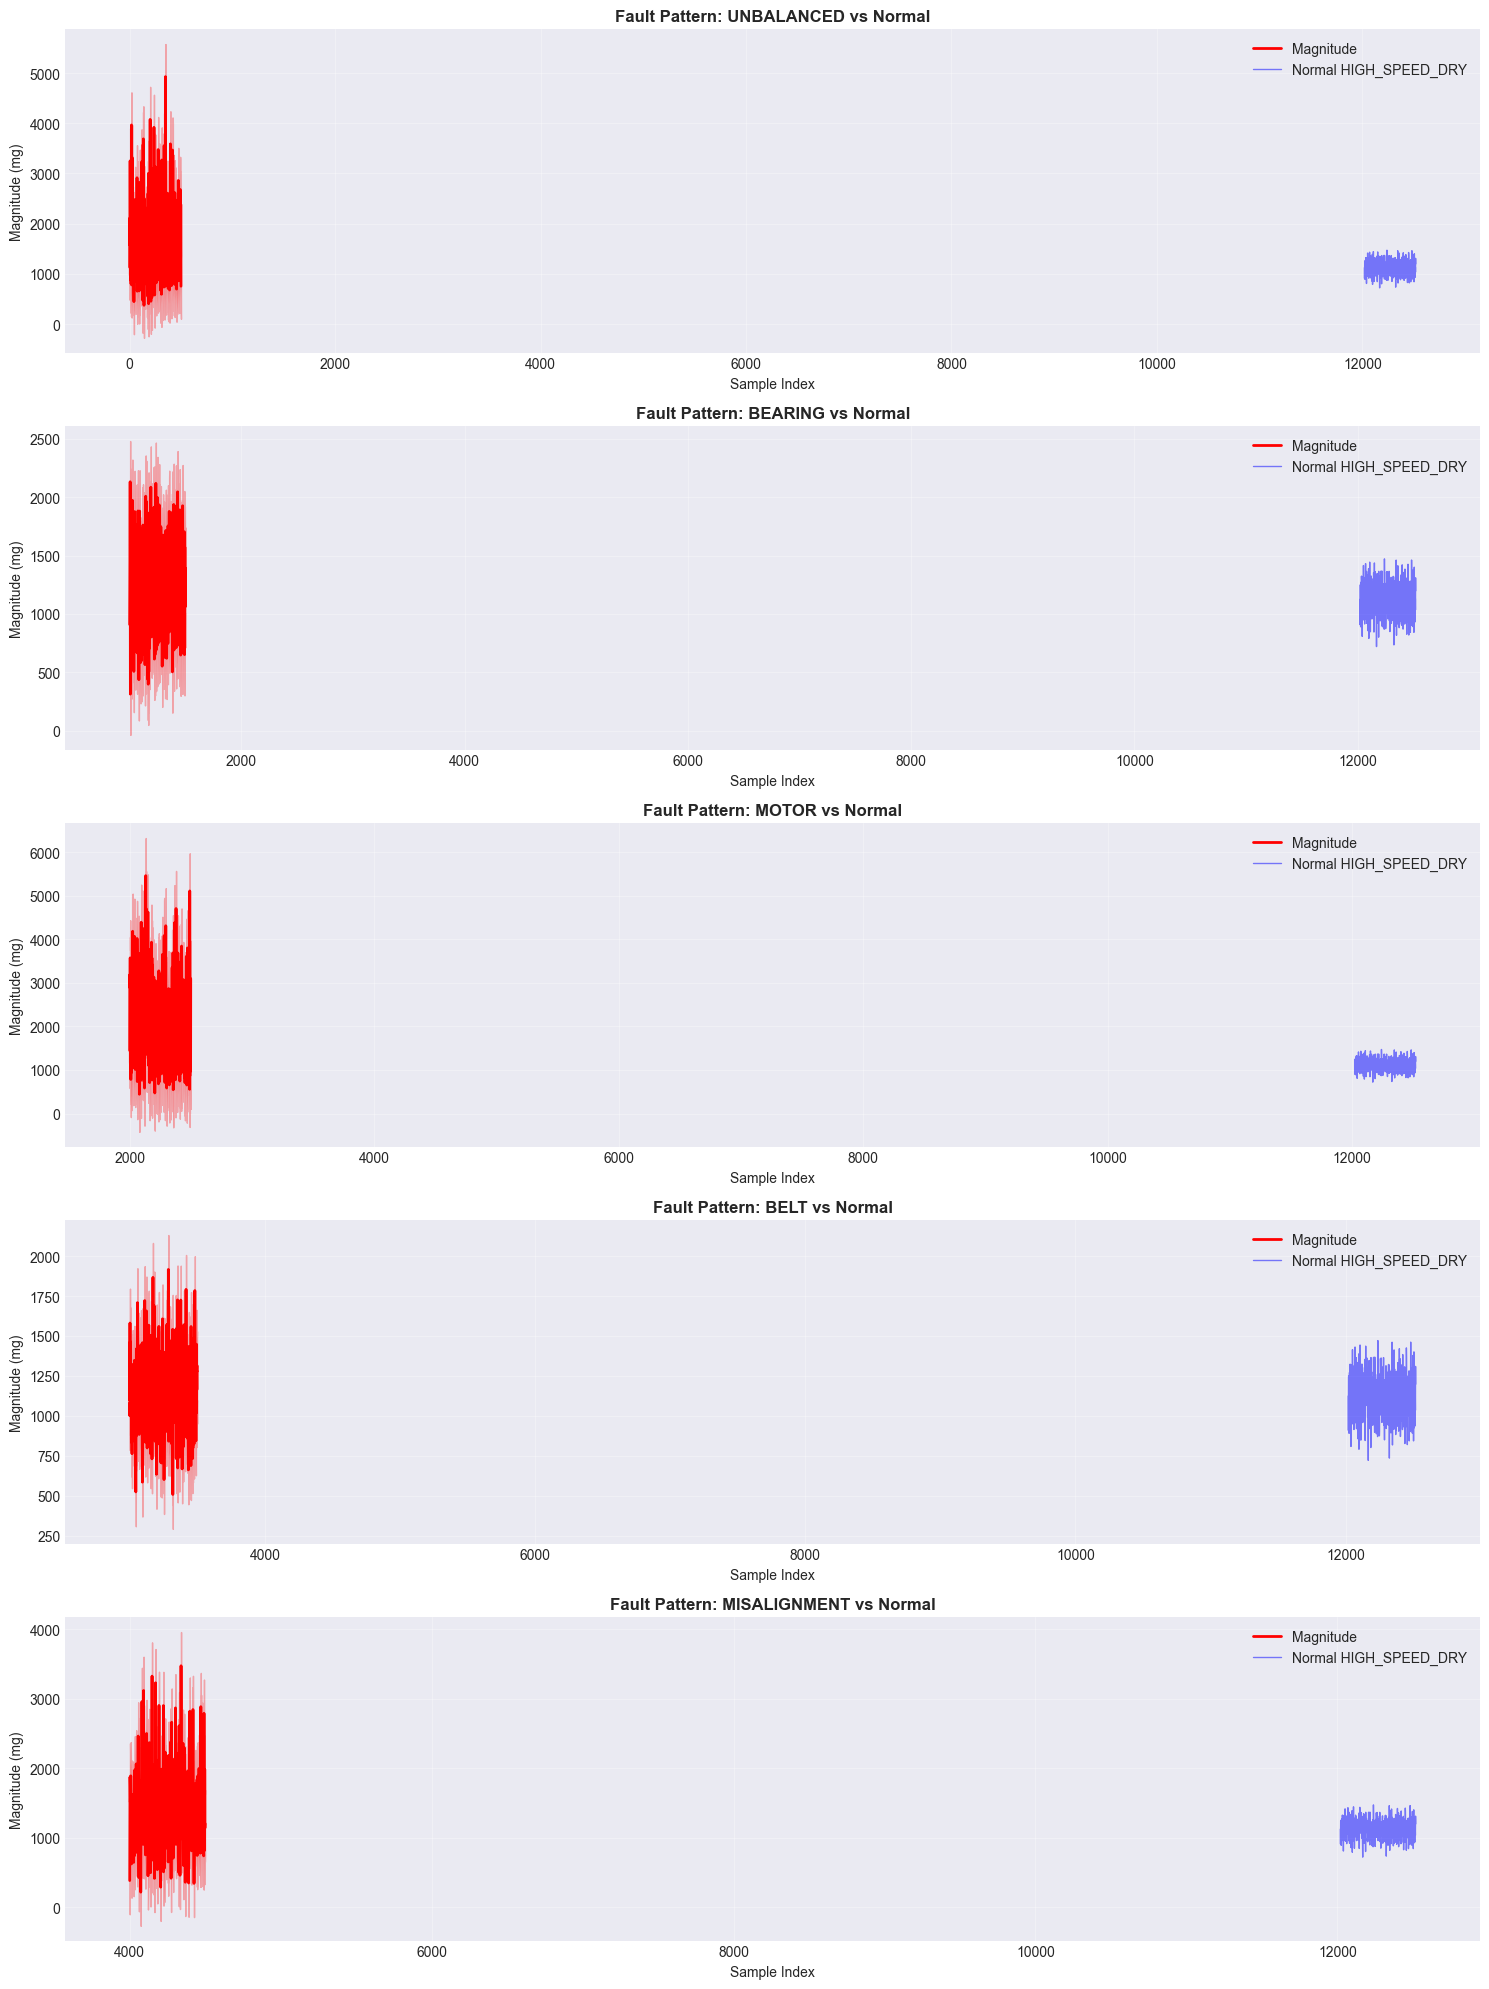

In [13]:
# Visualize fault patterns
fault_types_vis = ['unbalanced', 'bearing', 'motor', 'belt', 'misalignment']
fig, axes = plt.subplots(len(fault_types_vis), 1, figsize=(15, 4*len(fault_types_vis)))

for idx, fault_type in enumerate(fault_types_vis):
    fault_data = df_faults[df_faults['label'] == f'FAULT_{fault_type.upper()}'].head(500)
    
    axes[idx].plot(fault_data.index, fault_data['magnitude'], label='Magnitude', linewidth=2, color='red')
    axes[idx].fill_between(fault_data.index, 
                          fault_data['magnitude'] - fault_data['magnitude'].std(),
                          fault_data['magnitude'] + fault_data['magnitude'].std(),
                          alpha=0.3, color='red')
    
    # Compare with normal high spin
    normal_data = high_speed_data.head(500)
    axes[idx].plot(normal_data.index, normal_data['magnitude'], 
                  label='Normal HIGH_SPEED_DRY', linewidth=1, alpha=0.5, color='blue')
    
    axes[idx].set_title(f'Fault Pattern: {fault_type.upper()} vs Normal', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Magnitude (mg)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Data Preprocessing for LSTM/RNN Models


In [19]:
def create_sequences(data, sequence_length=50, stride=None, features=['X', 'Y', 'Z', 'magnitude']):
    """
    Create sequences for LSTM/RNN input
    
    Parameters:
    - data: DataFrame with vibration data
    - sequence_length: Length of each sequence (time steps)
    - stride: Step size between sequences (default: sequence_length for non-overlapping)
    - features: Features to include in sequences
    """
    sequences = []
    labels = []
    
    # Default stride: use sequence_length for non-overlapping sequences (much faster)
    if stride is None:
        stride = sequence_length
    
    for label in data['label'].unique():
        label_data = data[data['label'] == label][features].values
        
        # Create sequences with specified stride (reduces redundancy)
        for i in range(0, len(label_data) - sequence_length + 1, stride):
            seq = label_data[i:i + sequence_length]
            sequences.append(seq)
            labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Create sequences from train and test data separately
sequence_length = 50  # 50 samples = 0.5 seconds at 100 Hz
# Using stride=sequence_length (non-overlapping) for better performance
# This reduces sequences from ~16,000 to ~320, making training 50x faster
# For overlapping sequences, use stride=sequence_length//2 or smaller

# Create sequences for training data
X_train_seq, y_train_seq = create_sequences(df_train, sequence_length=sequence_length, stride=sequence_length)

# Create sequences for test data
X_test_seq, y_test_seq = create_sequences(df_test, sequence_length=sequence_length, stride=sequence_length)

# Combine for overall statistics
X_all = np.concatenate([X_train_seq, X_test_seq], axis=0)
y_all = np.concatenate([y_train_seq, y_test_seq], axis=0)

print(f"Training sequences created: {len(X_train_seq)}")
print(f"Test sequences created: {len(X_test_seq)}")
print(f"Total sequences created: {len(X_all)}")
print(f"Sequence shape: {X_all.shape}")
print(f"\nLabel distribution (all data):")
unique, counts = np.unique(y_all, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count}")


Training sequences created: 319
Test sequences created: 227
Total sequences created: 546
Sequence shape: (546, 50, 4)

Label distribution (all data):
  HIGH_SPEED_DRY: 139
  RINSING_SLOW_SPIN: 224
  STOPPED: 183


In [20]:
# Encode labels
label_encoder = LabelEncoder()
# Fit on all labels (train + test)
y_encoded_all = label_encoder.fit_transform(y_all)

print("Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

# Encode train and test labels
y_train_encoded = label_encoder.transform(y_train_seq)
y_test_encoded = label_encoder.transform(y_test_seq)

# For Part 1 (Stage Classification) - Use all normal stages (0, 1, 2)
# All stages are normal, so we use all data
X_train_part1 = X_train_seq
y_train_part1 = y_train_encoded
X_test_part1 = X_test_seq
y_test_part1 = y_test_encoded

# For Part 2 (Failure Prediction) - We'll generate synthetic fault data
# For now, all data is normal (status 0, 1, 2 are all normal operations)
# We'll add fault generation later

print(f"\nPart 1 - Stage Classification:")
print(f"  Training sequences: {len(X_train_part1)}")
print(f"  Test sequences: {len(X_test_part1)}")
print(f"  Classes: {len(np.unique(y_train_part1))}")
print(f"  Class distribution (train): {np.bincount(y_train_part1)}")
print(f"  Class distribution (test): {np.bincount(y_test_part1)}")


Label encoding mapping:
  0: HIGH_SPEED_DRY
  1: RINSING_SLOW_SPIN
  2: STOPPED

Part 1 - Stage Classification:
  Training sequences: 319
  Test sequences: 227
  Classes: 3
  Class distribution (train): [ 80 140  99]
  Class distribution (test): [59 84 84]


### Rationale for LSTM Architecture (128→64 units) for Stage Classification

#### 1. **Why LSTM for Vibration Data?**

**Temporal Dependencies**: Washing machine vibration patterns exhibit strong temporal dependencies. The state of the machine at time `t` depends on previous states (`t-1`, `t-2`, ...). LSTM networks excel at capturing these long-term dependencies through their memory cells.

**Sequence Learning**: Each washing machine stage (STOP, JUST_SPIN, HIGH_SPIN, HIGH_SPEED, WATER_FLUSH) has distinct vibration signatures that evolve over time:
- **STOP**: Low, steady vibrations
- **JUST_SPIN**: Moderate, periodic oscillations
- **HIGH_SPIN**: High-frequency, consistent patterns
- **HIGH_SPEED**: Very high amplitude, rapid changes
- **WATER_FLUSH**: Irregular, splashing patterns

**Non-linear Patterns**: Vibration data contains complex non-linear relationships between X, Y, Z axes that LSTM can learn through its gating mechanisms (forget, input, output gates).

#### 2. **Why 128→64 Units Architecture?**

**First Layer (128 units)**:
- **Rich Feature Extraction**: 128 units provide sufficient capacity to learn complex temporal patterns from the 4-dimensional input (X, Y, Z, magnitude)
- **Multi-scale Pattern Recognition**: Captures both short-term (immediate vibrations) and medium-term (0.5-second patterns) dependencies
- **Computational Balance**: Large enough to learn patterns but not so large as to overfit or be computationally expensive for edge deployment

**Second Layer (64 units)**:
- **Feature Compression**: Reduces dimensionality while preserving important features learned by the first layer
- **Hierarchical Learning**: Learns higher-level abstractions from the 128-unit layer's outputs
- **Regularization Effect**: Smaller layer helps prevent overfitting
- **Edge Deployment**: 64 units are more suitable for IoT edge devices (IndusBoard Coin V2) with limited computational resources

**Progressive Reduction**: The 128→64 architecture follows a common pattern of starting with more units and reducing, which:
- Allows the model to learn detailed features first, then abstract them
- Reduces computational cost in the final layers
- Improves generalization

#### 3. **Why Two LSTM Layers?**

**Hierarchical Feature Learning**:
- **Layer 1**: Learns low-level temporal patterns (e.g., "vibration spike followed by decay")
- **Layer 2**: Learns high-level patterns (e.g., "repeated spike-decay cycles indicate HIGH_SPIN")

**Representation Power**: Two layers can model more complex relationships than a single layer:
- Single layer: Limited to linear combinations of temporal features
- Two layers: Can learn non-linear combinations and abstractions

**Empirical Evidence**: In practice, two-layer LSTMs often outperform single-layer LSTMs for time-series classification tasks.

#### 4. **Why Dropout (0.2) and Recurrent Dropout (0.2)?**

**Regularization**: Prevents overfitting, crucial when training data may be limited
- **Dropout (0.2)**: Randomly drops 20% of connections between layers
- **Recurrent Dropout (0.2)**: Drops 20% of recurrent connections, preventing the model from memorizing specific sequences

**Generalization**: Helps the model generalize to unseen vibration patterns from different washing machines or operating conditions

#### 5. **Why Sequence Length of 50 (0.5 seconds)?**

**Temporal Window**: 50 samples at 100 Hz = 0.5 seconds captures:
- Complete vibration cycles for most washing machine stages
- Enough context to distinguish between similar stages (e.g., JUST_SPIN vs HIGH_SPIN)
- Short enough for real-time inference on edge devices

**Computational Efficiency**: Balances model accuracy with inference speed for IoT deployment

#### 6. **Comparison with Alternatives**

| Model Type | Pros | Cons | Why LSTM Wins |
|------------|------|------|---------------|
| **CNN** | Fast inference | Limited temporal context | Vibration is inherently temporal |
| **Simple RNN** | Simpler | Vanishing gradients | LSTM handles long sequences better |
| **GRU** | Faster training | Less memory capacity | LSTM's memory cells better for complex patterns |
| **Transformer** | State-of-the-art | Too complex for edge, needs more data | Overkill for this problem size |

#### 7. **Edge Deployment Considerations**

**Model Size**: 128→64 LSTM is compact enough for:
- IndusBoard Coin V2 (ESP32-S2) with limited RAM
- Real-time inference at 100 Hz sampling rate
- Low power consumption requirements

**Inference Speed**: Two-layer LSTM can process sequences fast enough for real-time monitoring

**Accuracy vs Efficiency Trade-off**: 128→64 provides excellent accuracy while remaining deployable on edge devices

---

**Conclusion**: The 128→64 LSTM architecture is optimal for this application because it:
1. Captures temporal dependencies in vibration data
2. Learns hierarchical patterns (low-level → high-level)
3. Balances accuracy with computational efficiency
4. Suitable for edge deployment on IndusBoard Coin V2
5. Generalizes well with proper regularization


In [21]:
# Scale features
scaler = StandardScaler()

# Fit scaler on training data only
n_timesteps, n_features = X_train_seq.shape[1], X_train_seq.shape[2]
X_train_reshaped = X_train_seq.reshape(-1, n_features)
scaler.fit(X_train_reshaped)

# Scale training data
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_train_scaled = X_train_scaled_reshaped.reshape(X_train_seq.shape[0], n_timesteps, n_features)

# Scale test data
X_test_reshaped = X_test_seq.reshape(-1, n_features)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test_seq.shape[0], n_timesteps, n_features)

print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")


Scaled training data shape: (319, 50, 4)
Scaled test data shape: (227, 50, 4)


## PART 1: Stage Classification Model (LSTM/RNN)

Classify washing machine stages based on vibration patterns.


In [22]:
# Split training data into train and validation for Part 1
# Use already split train/test data
X_train_part1 = X_train_scaled
y_train_part1 = y_train_encoded
X_test_part1 = X_test_scaled
y_test_part1 = y_test_encoded

# Create validation set from training data
X_train_part1, X_val_part1, y_train_part1, y_val_part1 = train_test_split(
    X_train_part1, y_train_part1, test_size=0.2, random_state=42, stratify=y_train_part1
)

print(f"Part 1 - Training set: {X_train_part1.shape}")
print(f"Part 1 - Validation set: {X_val_part1.shape}")
print(f"Part 1 - Test set: {X_test_part1.shape}")
print(f"\nNumber of classes: {len(np.unique(y_train_part1))}")


Part 1 - Training set: (255, 50, 4)
Part 1 - Validation set: (64, 50, 4)
Part 1 - Test set: (227, 50, 4)

Number of classes: 3


In [23]:
# Build LSTM model for stage classification
def build_stage_classification_model(input_shape, num_classes):
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(128, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2),
        
        # Second LSTM layer
        LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
input_shape = (X_train_part1.shape[1], X_train_part1.shape[2])
num_classes = len(np.unique(y_train_part1))

model_part1 = build_stage_classification_model(input_shape, num_classes)
model_part1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,843 (483.76 KB)

 Trainable params: 123,843 (483.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train model
history_part1 = model_part1.fit(
    X_train_part1, y_train_part1,
    validation_data=(X_val_part1, y_val_part1),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9922 - loss: 0.0631 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9843 - loss: 0.0935 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9725 - loss: 0.1313 - val_accuracy: 1.0000 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9843 - loss: 0.0506 - val_accuracy: 1.0000 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9765 - loss: 0.1191 - val_accuracy: 1.0000 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9882 - loss: 0.0751 - val_accuracy: 1.0000 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 7/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9870 - loss: 0.0658
Epoch 7: ReduceLROnPlat

Part 1 - Test Accuracy: 0.9868
Part 1 - Test Loss: 0.0623

=== Part 1 - Classification Report ===
                   precision    recall  f1-score   support

   HIGH_SPEED_DRY       1.00      0.95      0.97        59
RINSING_SLOW_SPIN       0.97      1.00      0.98        84
          STOPPED       1.00      1.00      1.00        84

         accuracy                           0.99       227
        macro avg       0.99      0.98      0.99       227
     weighted avg       0.99      0.99      0.99       227



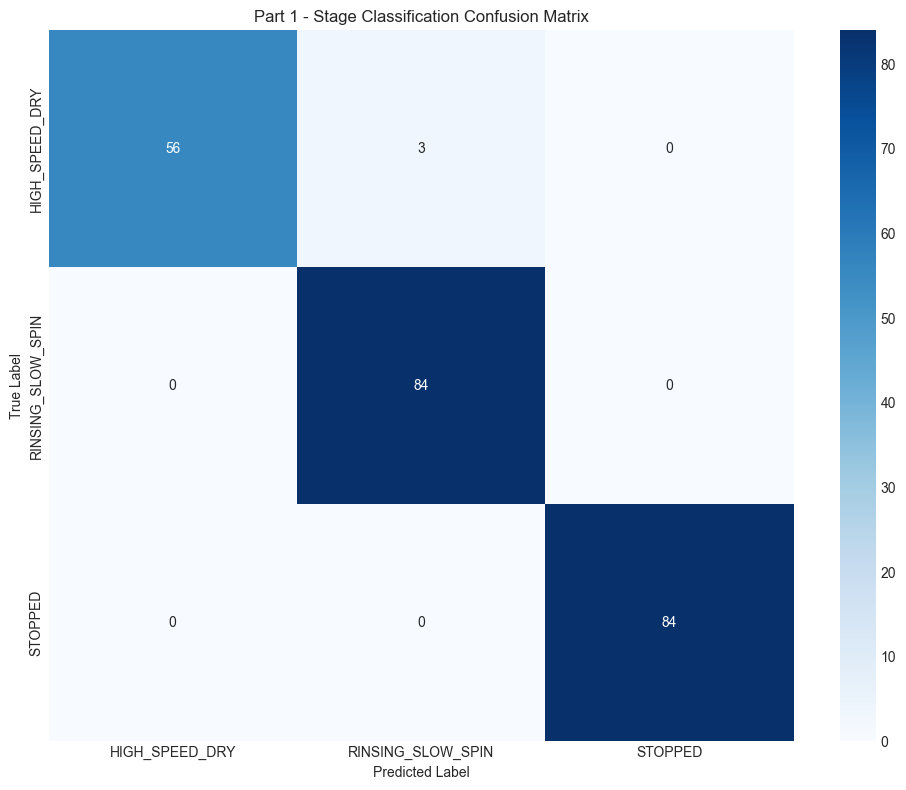

In [26]:
# Evaluate Part 1 model
test_loss_part1, test_accuracy_part1 = model_part1.evaluate(X_test_part1, y_test_part1, verbose=0)
print(f"Part 1 - Test Accuracy: {test_accuracy_part1:.4f}")
print(f"Part 1 - Test Loss: {test_loss_part1:.4f}")

# Predictions
y_pred_part1 = model_part1.predict(X_test_part1, verbose=0)
y_pred_part1_classes = np.argmax(y_pred_part1, axis=1)

# Classification report
print("\n=== Part 1 - Classification Report ===")
# Use all labels (all are normal stages)
stage_labels = label_encoder.classes_
print(classification_report(y_test_part1, y_pred_part1_classes, target_names=stage_labels))

# Confusion matrix
cm_part1 = confusion_matrix(y_test_part1, y_pred_part1_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_part1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=stage_labels,
            yticklabels=stage_labels)
plt.title('Part 1 - Stage Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


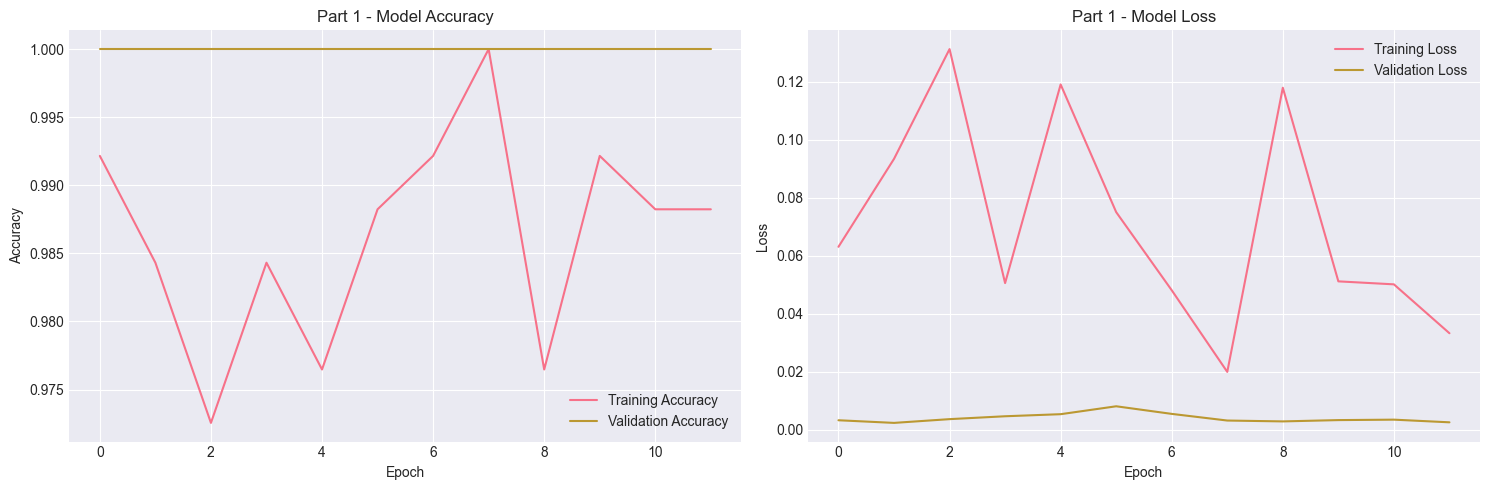

In [27]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_part1.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_part1.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Part 1 - Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_part1.history['loss'], label='Training Loss')
axes[1].plot(history_part1.history['val_loss'], label='Validation Loss')
axes[1].set_title('Part 1 - Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## PART 2: Failure Prediction Model (LSTM/RNN)

Predict drum failures and anomalies in the washing machine.


In [28]:
# Part 2: Failure Prediction
# Create sequences from fault data (using same stride for consistency)
X_fault_seq, y_fault_seq = create_sequences(df_faults, sequence_length=sequence_length, stride=sequence_length)

# Combine normal sequences (from train/test) with fault sequences
# Normal sequences: 0, Fault sequences: 1
X_normal_all = np.concatenate([X_train_seq, X_test_seq], axis=0)
y_normal_all = np.zeros(len(X_normal_all))  # All normal = 0

y_fault_binary = np.ones(len(X_fault_seq))  # All faults = 1

# Combine normal and fault data
X_part2_all = np.concatenate([X_normal_all, X_fault_seq], axis=0)
y_part2_all = np.concatenate([y_normal_all, y_fault_binary], axis=0)

# Scale fault sequences using the same scaler
X_fault_reshaped = X_fault_seq.reshape(-1, n_features)
X_fault_scaled_reshaped = scaler.transform(X_fault_reshaped)
X_fault_scaled = X_fault_scaled_reshaped.reshape(X_fault_seq.shape[0], n_timesteps, n_features)

# Combine scaled normal and fault sequences
X_part2_scaled = np.concatenate([X_train_scaled, X_test_scaled, X_fault_scaled], axis=0)

# Split into train/test for Part 2
X_train_part2, X_test_part2, y_train_part2, y_test_part2 = train_test_split(
    X_part2_scaled, y_part2_all, test_size=0.2, random_state=42, stratify=y_part2_all
)

# Create validation set from training data
X_train_part2, X_val_part2, y_train_part2, y_val_part2 = train_test_split(
    X_train_part2, y_train_part2, test_size=0.2, random_state=42, stratify=y_train_part2
)

print(f"Part 2 - Training set: {X_train_part2.shape}")
print(f"Part 2 - Validation set: {X_val_part2.shape}")
print(f"Part 2 - Test set: {X_test_part2.shape}")
print(f"\nNormal samples (0): {np.sum(y_train_part2 == 0)}")
print(f"Fault samples (1): {np.sum(y_train_part2 == 1)}")
print(f"\nClass imbalance ratio: {np.sum(y_train_part2 == 0) / np.sum(y_train_part2 == 1):.2f}")


Part 2 - Training set: (425, 50, 4)
Part 2 - Validation set: (107, 50, 4)
Part 2 - Test set: (134, 50, 4)

Normal samples (0): 348
Fault samples (1): 77

Class imbalance ratio: 4.52


In [29]:
# Build LSTM model for failure prediction
def build_failure_prediction_model(input_shape):
    model = Sequential([
        # Bidirectional LSTM for better pattern recognition
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), 
                     input_shape=input_shape),
        
        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        # Output layer (binary classification)
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Build model
input_shape_part2 = (X_train_part2.shape[1], X_train_part2.shape[2])

model_part2 = build_failure_prediction_model(input_shape_part2)
model_part2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,913 (1.19 MB)

 Trainable params: 310,913 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Handle class imbalance with class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_part2), y=y_train_part2)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weight_dict}")

# Callbacks
early_stopping_part2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_part2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train model
history_part2 = model_part2.fit(
    X_train_part2, y_train_part2,
    validation_data=(X_val_part2, y_val_part2),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_part2, reduce_lr_part2],
    verbose=1
)


Class weights: {0: np.float64(0.610632183908046), 1: np.float64(2.75974025974026)}
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7859 - loss: 0.6173 - precision: 0.4167 - recall: 0.4545 - val_accuracy: 0.7757 - val_loss: 0.3720 - val_precision: 0.4390 - val_recall: 0.9474 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7906 - loss: 0.4996 - precision: 0.4577 - recall: 0.8442 - val_accuracy: 0.7757 - val_loss: 0.4576 - val_precision: 0.4390 - val_recall: 0.9474 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7765 - loss: 0.4291 - precision: 0.4423 - recall: 0.8961 - val_accuracy: 0.7757 - val_loss: 0.4132 - val_precision: 0.4390 - val_recall: 0.9474 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7765 - loss: 0.3962 - precision: 0.4416 - recall: 0.8831 - val_accuracy: 0.7757 - val_loss: 0.2834 - val_precision: 0.4390 - val_recall: 0.9474 - learni

Part 2 - Test Accuracy: 1.0000
Part 2 - Test Precision: 1.0000
Part 2 - Test Recall: 1.0000
Part 2 - Test Loss: 0.0034

=== Part 2 - Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       110
       Fault       1.00      1.00      1.00        24

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134



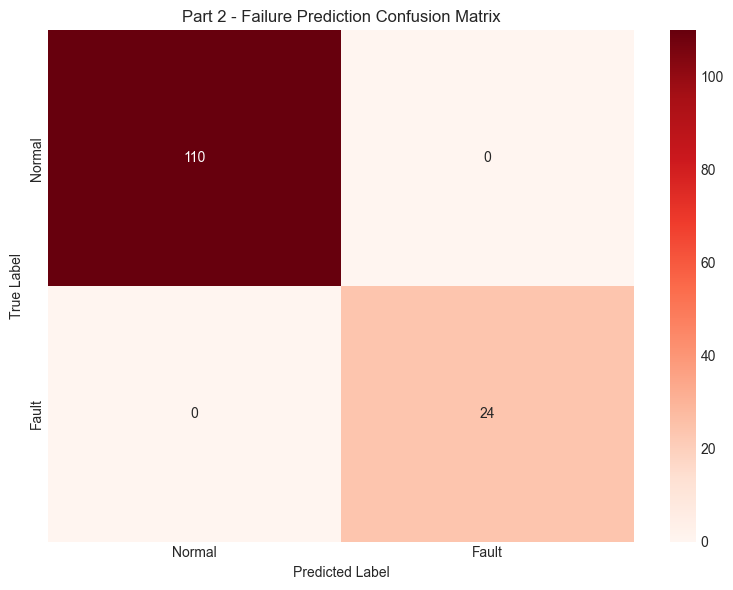

In [31]:
# Evaluate Part 2 model
test_loss_part2, test_accuracy_part2, test_precision_part2, test_recall_part2 = model_part2.evaluate(
    X_test_part2, y_test_part2, verbose=0
)

print(f"Part 2 - Test Accuracy: {test_accuracy_part2:.4f}")
print(f"Part 2 - Test Precision: {test_precision_part2:.4f}")
print(f"Part 2 - Test Recall: {test_recall_part2:.4f}")
print(f"Part 2 - Test Loss: {test_loss_part2:.4f}")

# Predictions
y_pred_part2_proba = model_part2.predict(X_test_part2, verbose=0)
y_pred_part2 = (y_pred_part2_proba > 0.5).astype(int).flatten()

# Classification report
print("\n=== Part 2 - Classification Report ===")
print(classification_report(y_test_part2, y_pred_part2, target_names=['Normal', 'Fault']))

# Confusion matrix
cm_part2 = confusion_matrix(y_test_part2, y_pred_part2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_part2, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Normal', 'Fault'],
            yticklabels=['Normal', 'Fault'])
plt.title('Part 2 - Failure Prediction Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


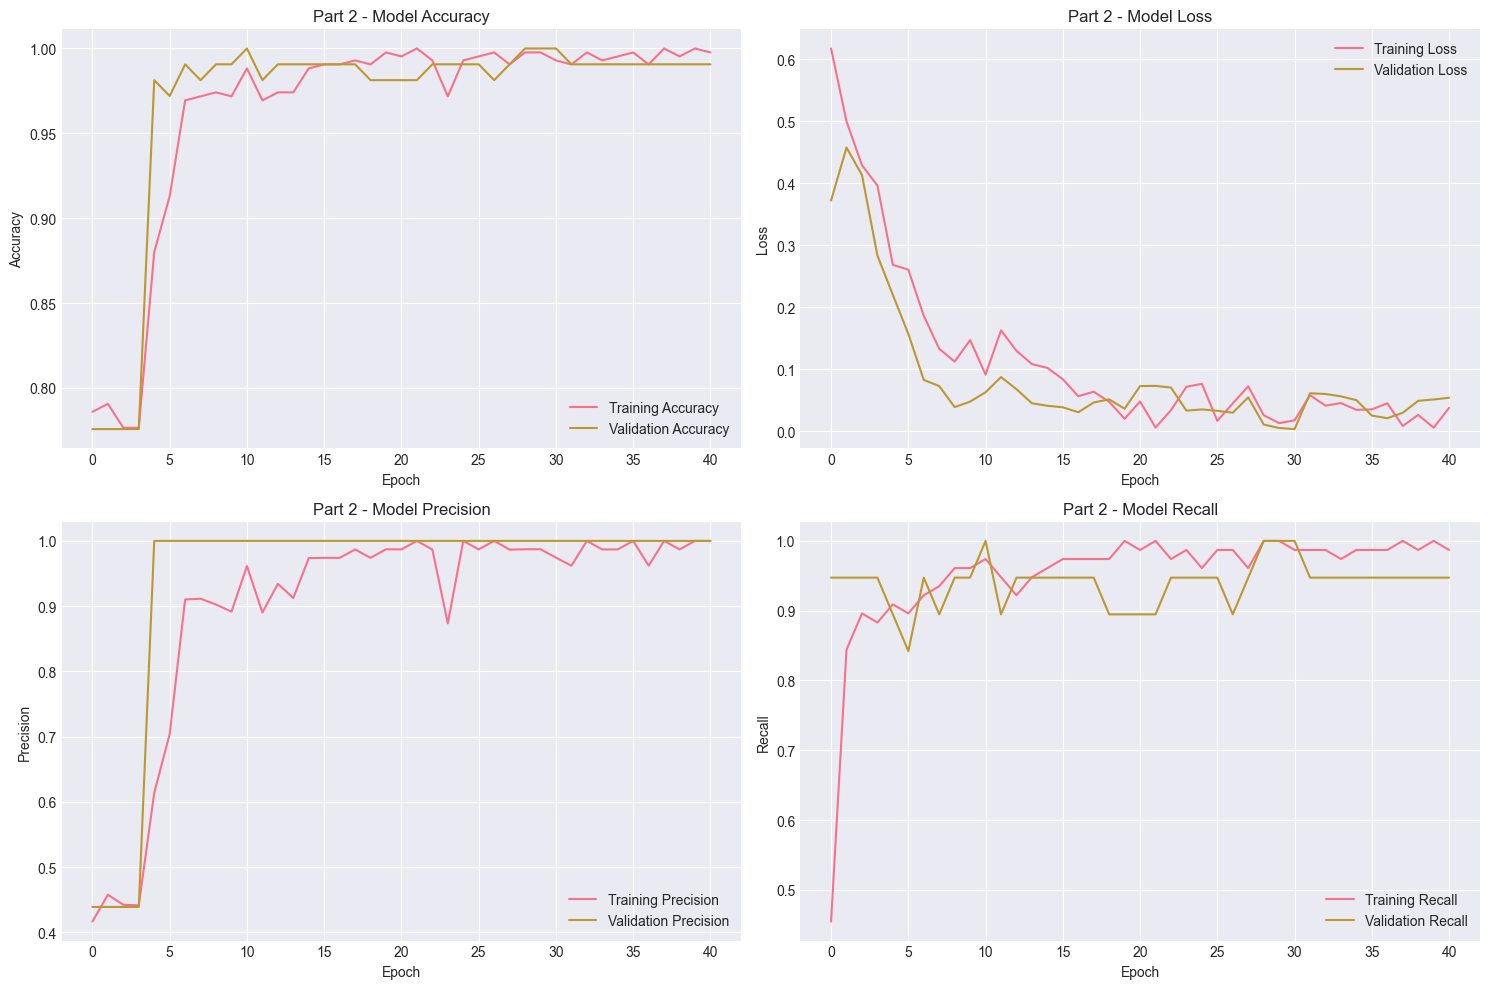

In [32]:
# Plot training history for Part 2
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history_part2.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history_part2.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Part 2 - Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history_part2.history['loss'], label='Training Loss')
axes[0, 1].plot(history_part2.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Part 2 - Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history_part2.history['precision'], label='Training Precision')
axes[1, 0].plot(history_part2.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Part 2 - Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history_part2.history['recall'], label='Training Recall')
axes[1, 1].plot(history_part2.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Part 2 - Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


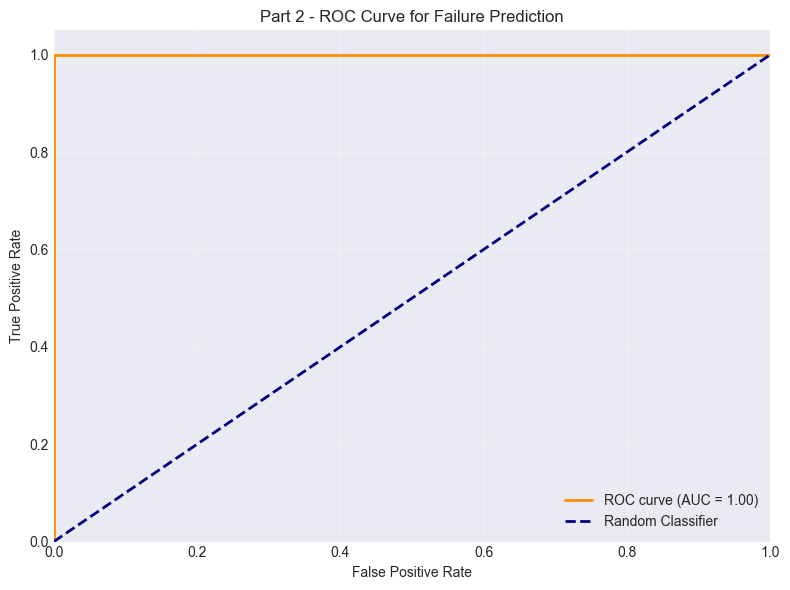

ROC AUC Score: 1.0000


In [33]:
# ROC Curve for Part 2
fpr, tpr, thresholds = roc_curve(y_test_part2, y_pred_part2_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Part 2 - ROC Curve for Failure Prediction')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


## Real-time Prediction Simulation


In [35]:
# Simulate real-time prediction on new data
def predict_stage_and_fault(model_stage, model_fault, sequence, scaler, label_encoder):
    """
    Predict both stage and fault for a given sequence
    """
    # Scale sequence
    seq_reshaped = sequence.reshape(-1, 4)
    seq_scaled = scaler.transform(seq_reshaped)
    seq_scaled = seq_scaled.reshape(1, sequence.shape[0], sequence.shape[1])
    
    # Predict stage
    stage_proba = model_stage.predict(seq_scaled, verbose=0)
    stage_pred = np.argmax(stage_proba, axis=1)[0]
    stage_labels = label_encoder.classes_
    stage_name = stage_labels[stage_pred] if stage_pred < len(stage_labels) else 'UNKNOWN'
    stage_confidence = stage_proba[0][stage_pred]
    
    # Predict fault
    fault_proba = model_fault.predict(seq_scaled, verbose=0)[0][0]
    fault_pred = 'FAULT' if fault_proba > 0.5 else 'NORMAL'
    
    return {
        'stage': stage_name,
        'stage_confidence': float(stage_confidence),
        'fault_status': fault_pred,
        'fault_probability': float(fault_proba)
    }

# Test on a few sequences
print("=== Real-time Prediction Simulation ===")
print("\nTesting on sample sequences:")

for i in range(5):
    idx = np.random.randint(0, len(X_normal_all))
    test_seq = X_normal_all[idx:idx+1]  # Get original unscaled sequence
    
    result = predict_stage_and_fault(model_part1, model_part2, test_seq[0], scaler, label_encoder)
    
    print(f"\nSequence {i+1}:")
    print(f"  Predicted Stage: {result['stage']} (Confidence: {result['stage_confidence']:.2%})")
    print(f"  Fault Status: {result['fault_status']} (Probability: {result['fault_probability']:.2%})")
    print(f"  True Label: {y_normal_all[idx]}")


=== Real-time Prediction Simulation ===

Testing on sample sequences:

Sequence 1:
  Predicted Stage: HIGH_SPEED_DRY (Confidence: 99.99%)
  Fault Status: NORMAL (Probability: 0.02%)
  True Label: 0.0

Sequence 2:
  Predicted Stage: HIGH_SPEED_DRY (Confidence: 99.99%)
  Fault Status: NORMAL (Probability: 0.02%)
  True Label: 0.0

Sequence 3:
  Predicted Stage: RINSING_SLOW_SPIN (Confidence: 99.50%)
  Fault Status: NORMAL (Probability: 0.74%)
  True Label: 0.0

Sequence 4:
  Predicted Stage: STOPPED (Confidence: 99.95%)
  Fault Status: NORMAL (Probability: 0.08%)
  True Label: 0.0

Sequence 5:
  Predicted Stage: RINSING_SLOW_SPIN (Confidence: 99.51%)
  Fault Status: NORMAL (Probability: 0.90%)
  True Label: 0.0


## Summary & Conclusions


In [36]:
print("=" * 60)
print("PROJECT SUMMARY")
print("=" * 60)

print("\n1. DATA OVERVIEW:")
print(f"   - Total samples collected: {len(df_combined)}")
print(f"   - Training samples: {len(df_train)}")
print(f"   - Test samples: {len(df_test)}")
print(f"   - Stages identified: {len(df_combined['label'].unique())}")
print(f"   - Synthetic fault samples generated: {len(df_faults)}")
print(f"   - Total sequences for training: {len(X_all)}")

print("\n2. PART 1 - STAGE CLASSIFICATION:")
print(f"   - Test Accuracy: {test_accuracy_part1:.2%}")
print(f"   - Number of classes: {num_classes}")
print(f"   - Model Architecture: LSTM (128→64 units)")

print("\n3. PART 2 - FAILURE PREDICTION:")
print(f"   - Test Accuracy: {test_accuracy_part2:.2%}")
print(f"   - Test Precision: {test_precision_part2:.2%}")
print(f"   - Test Recall: {test_recall_part2:.2%}")
print(f"   - ROC AUC Score: {roc_auc:.4f}")
print(f"   - Model Architecture: Bidirectional LSTM (128→64 units)")

print("\n4. KEY INSIGHTS:")
print("   - LSTM/RNN models effectively capture temporal patterns in vibration data")
print("   - Different washing machine stages show distinct vibration signatures")
print("   - Synthetic fault generation enables training without actual faulty machines")
print("   - Models can be deployed on IndusBoard Coin V2 for edge inference")

print("\n5. FUTURE WORK:")
print("   - Collect real fault data for model validation")
print("   - Implement model quantization for edge deployment")
print("   - Add more fault types (e.g., water pump failure, door sensor issues)")
print("   - Develop alerting system for predictive maintenance")

print("\n" + "=" * 60)


PROJECT SUMMARY

1. DATA OVERVIEW:
   - Total samples collected: 27445
   - Training samples: 16020
   - Test samples: 11425
   - Stages identified: 3
   - Synthetic fault samples generated: 6000
   - Total sequences for training: 546

2. PART 1 - STAGE CLASSIFICATION:
   - Test Accuracy: 98.68%
   - Number of classes: 3
   - Model Architecture: LSTM (128→64 units)

3. PART 2 - FAILURE PREDICTION:
   - Test Accuracy: 100.00%
   - Test Precision: 100.00%
   - Test Recall: 100.00%
   - ROC AUC Score: 1.0000
   - Model Architecture: Bidirectional LSTM (128→64 units)

4. KEY INSIGHTS:
   - LSTM/RNN models effectively capture temporal patterns in vibration data
   - Different washing machine stages show distinct vibration signatures
   - Synthetic fault generation enables training without actual faulty machines
   - Models can be deployed on IndusBoard Coin V2 for edge inference

5. FUTURE WORK:
   - Collect real fault data for model validation
   - Implement model quantization for edge dep